# Atlanta Crime - Supervised Learning

## Description
In this part of the project, we will use supervised learning algorithms, namely, Decision Trees/Random Forests, NBC, SVM, and Logistic Regression algorithms to predict crime score for a given location and time.

## Import Packages

In [206]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import plot_tree
from sklearn.tree.export import export_text
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import datetime
import random
import numpy as np
import time
import matplotlib.pyplot as plt

## Load in Data

In [164]:
# data = pd.read_csv("data/examples/cobra_example_10.csv") #, sep=',', header=0, engine='python', usecols = lambda column : column in ["Neighborhood", "Month", "Day", "Shift"])
data = pd.read_csv("cobra-counts.csv")
training_data = pd.read_csv("cobra-clean2.csv", sep=',', header=0, usecols = lambda column : column in ["Occur Time", "Neighborhood", "Shift Occurence", "Day of Week", "Crime Category"])

# There are some null values in both cobra-cleans, getting rid of their rows
# Pretty sure only "Null" is needed, but whatever
training_data = training_data[~training_data['Neighborhood'].isin(["Null", None, "null"])]

data['Crime Score'] = 1000 * data['Category 1'] + 100 * data['Category 2'] + 10 * data['Category 3'] + 1 * data['Category 4']
data = data.drop(["Categories", "Category 1", "Category 2", "Category 3", "Category 4"], 1)

# Shuffle, for now, until 2019 CSV is available
# (Might need) df = df.sample(frac=1).reset_index(drop=True)
training_data = training_data.sample(frac=1)
# training_data.head()

data = data.sample(frac=1)
data.head()

,Neighborhood,Month,Day,Shift,Crime Score
35027,Peachtree Heights East,12,6,Evening,0
17479,East Lake,5,2,Day,32
47585,West Paces Ferry/Northside,10,6,Evening,13
32850,Oakcliff,5,2,Morning,0
25932,Just Us,11,6,Morning,0


In [165]:
# For now, test data is the latter 10% of training data (after shuffling)

test_data = training_data[int(0.10 * len(training_data)):]
training_data = training_data[:int(0.10 * len(training_data))]

# test_data.head()

data2 = data[int(0.10 * len(data)):]
data = data[:int(0.10 * len(data))]
data2.head()

,Neighborhood,Month,Day,Shift,Crime Score
47289,West Manor,8,6,Morning,0
32800,Oakcliff,2,6,Day,0
14851,Collier Hills,12,1,Day,1
34409,Paces,7,3,Evening,2
15425,Cross Creek,3,3,Evening,20


### Transforming the data

In [166]:
le = preprocessing.LabelEncoder()
le.fit(training_data["Neighborhood"])
training_data["Neighborhood"] = le.transform(training_data["Neighborhood"])
le.fit(training_data["Shift Occurence"])
training_data["Shift Occurence"] = le.transform(training_data["Shift Occurence"])

# training_data.head()

le = preprocessing.LabelEncoder()
le.fit(data["Neighborhood"])
data["Neighborhood"] = le.transform(data["Neighborhood"])
le.fit(data["Shift"])
data["Shift"] = le.transform(data["Shift"])

data.head()

,Neighborhood,Month,Day,Shift,Crime Score
35027,138,12,6,1,0
17479,69,5,2,0,32
47585,188,10,6,1,13
32850,130,5,2,2,0
25932,102,11,6,2,0


In [167]:
le = preprocessing.LabelEncoder()
le.fit(test_data["Neighborhood"])
test_data["Neighborhood"] = le.transform(test_data["Neighborhood"])
le.fit(test_data["Shift Occurence"])
test_data["Shift Occurence"] = le.transform(test_data["Shift Occurence"])

# test_data.head()

le = preprocessing.LabelEncoder()
le.fit(data2["Neighborhood"])
data2["Neighborhood"] = le.transform(data2["Neighborhood"])
le.fit(data2["Shift"])
data2["Shift"] = le.transform(data2["Shift"])

data2.head()

,Neighborhood,Month,Day,Shift,Crime Score
47289,187,8,6,2,0
32800,130,2,6,0,0
14851,58,12,1,0,1
34409,136,7,3,1,2
15425,61,3,3,1,20


## Metrics & Plots

### Splitting data into training and test features and labels: X is features, y is label

In [169]:
# Reading data & split into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)
# Geeksforgeeks: "random_state" variable is a pseudo-random number generator state used for random sampling

# We need the cobra-clean for 2019 to use for the test data
X_train = training_data.drop(['Crime Category'], 1)
y_train = training_data['Crime Category']
X_test = test_data.drop(['Crime Category'], 1)
y_test = test_data['Crime Category']

X_train2 = data.drop(['Crime Score'], 1)
y_train2 = data['Crime Score']
X_test2 = data2.drop(['Crime Score'], 1)
y_test2 = data2['Crime Score']

In [170]:
def model_fitting(X_train, y_train, X_test, model):
    start_time = time.time()
    # Model Definition & Fitting
    if model == "dt":
        clf = DecisionTreeClassifier()
    elif model == "rf":
        clf = RandomForestClassifier(n_estimators=50)
    elif model == "nbc":
        clf = GaussianNB()
    elif model == "svm":
        clf = SVC(gamma='auto', probability=True)
    elif model == "lr":
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    else:
        print("Unrecognized model", model)
        return
    clf = clf.fit(X_train, y_train)
    # Predict based on the given features for the test set
    y_pred = clf.predict(X_test)
    predictions_probability = clf.predict_proba(X_test)
    end_time = time.time()
    return (clf, y_pred, predictions_probability, end_time - start_time)

## Models, Definition & Fitting

### Decision Tree Models

In [171]:
dt_clf, dt_y_pred, dt_predictions_probability, dt_elapsed_time = model_fitting(X_train, y_train, X_test, "dt")

In [ ]:
dt_clf2, dt_y_pred2, dt_predictions_probability2, dt_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "dt")

### Random Forest Models

In [172]:
rf_clf, rf_y_pred, rf_predictions_probability, rf_elapsed_time = model_fitting(X_train, y_train, X_test, "rf")

In [ ]:
rf_clf2, rf_y_pred2, rf_predictions_probability2, rf_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "rf")

### NBC Models

In [173]:
nbc_clf, nbc_y_pred, nbc_predictions_probability, nbc_elapsed_time = model_fitting(X_train, y_train, X_test, "nbc")

In [ ]:
nbc_clf2, nbc_y_pred2, nbc_predictions_probability2, nbc_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "nbc")

### SVM Models

In [140]:
svm_clf, svm_y_pred, svm_predictions_probability, svm_elapsed_time = model_fitting(X_train, y_train, X_test, "svm")

In [200]:
svm_clf2, svm_y_pred2, svm_predictions_probability2, svm_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "svm")

### Logistic Regressions

In [195]:
lr_clf, lr_y_pred, lr_predictions_probability, lr_elapsed_time = model_fitting(X_train, y_train, X_test, "lr")

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
lr_clf2, lr_y_pred2, lr_predictions_probability2, lr_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "lr")

## Plots

In [202]:
print(dt_elapsed_time, rf_elapsed_time, nbc_elapsed_time, svm_elapsed_time, lr_elapsed_time)
print(dt_elapsed_time2, rf_elapsed_time2, nbc_elapsed_time2, svm_elapsed_time2, lr_elapsed_time2)

0.18622899055480957 7.139418125152588 0.10918498039245605 526.3104598522186 0.6904380321502686
0.42844581604003906 28.045406818389893 7.925123691558838 2128.0168709754944 8.655764102935791


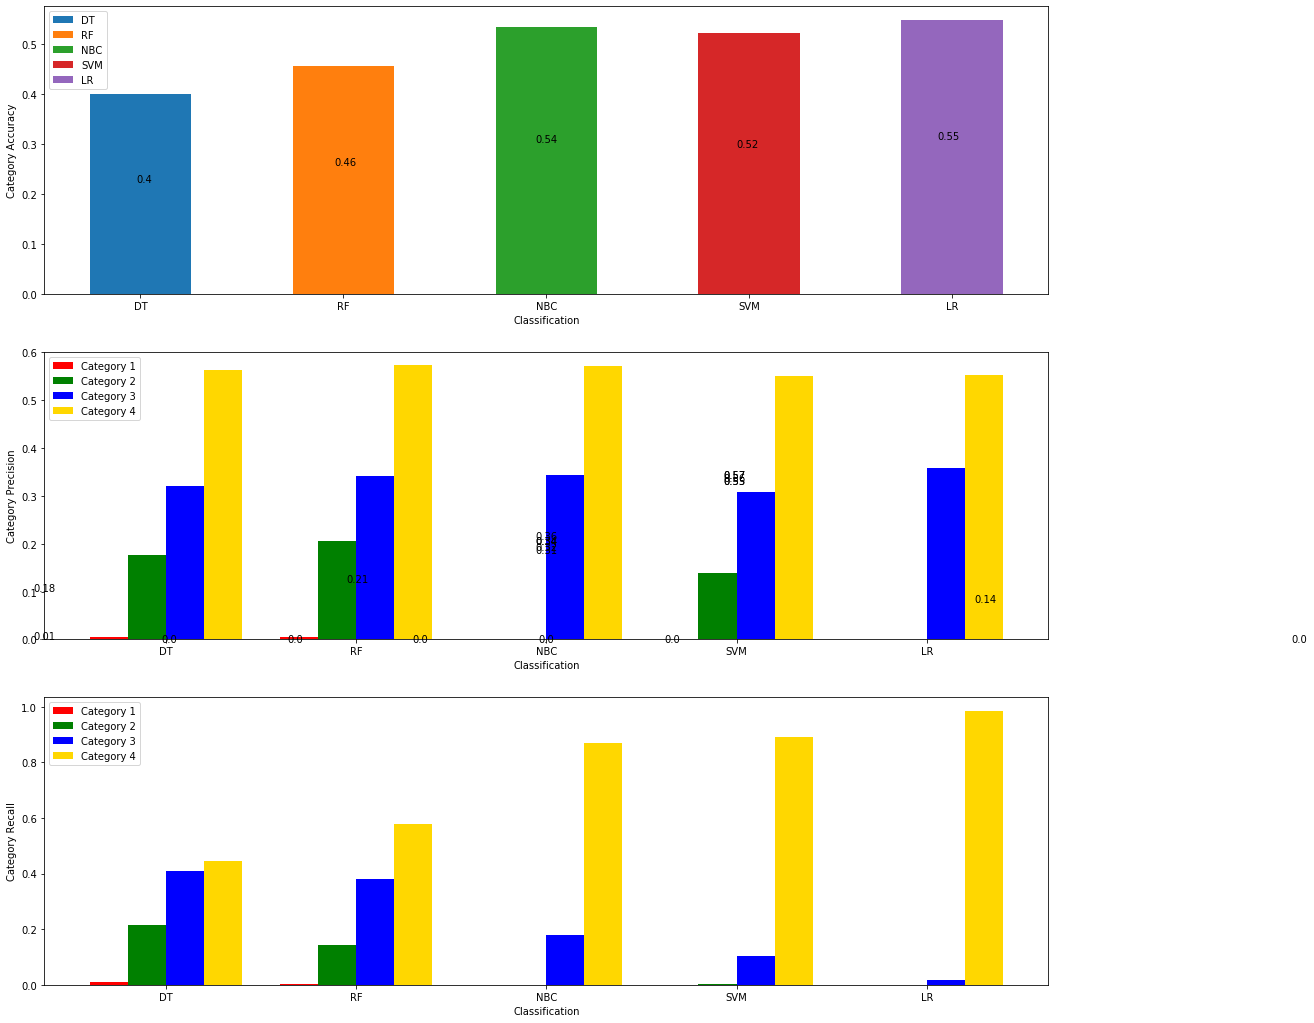

In [343]:
def apr(y_test, y_pred):
    # print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # print("Precision (average=None):", metrics.precision_score(y_test, y_pred, average=None))
    # print("Precision (average='micro'):", metrics.precision_score(y_test, y_pred, average='micro'))
    # print("Precision (average='macro'):", metrics.precision_score(y_test, y_pred, average='macro'))
    # print("Precision (average='weighted'):", metrics.precision_score(y_test, y_pred, average='weighted'))

    # print("Recall (average=None):", metrics.recall_score(y_test, y_pred, average=None))
    # print("Recall (average='micro'):", metrics.recall_score(y_test, y_pred, average='micro'))
    # print("Recall (average='macro'):", metrics.recall_score(y_test, y_pred, average='macro'))
    # print("Recall (average='weighted'):", metrics.recall_score(y_test, y_pred, average='weighted'))
    
    # print()
    
    return metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred, average=None), metrics.recall_score(y_test, y_pred, average=None)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,18))
for i, y_pred in enumerate([dt_y_pred, rf_y_pred, nbc_y_pred, svm_y_pred, lr_y_pred]):
    acc_prec_rec = apr(y_test, y_pred)

    ax1.bar(i, acc_prec_rec[0], width=0.5)
    ax1.text(0.1 + i * 0.2, round(acc_prec_rec[0], 2), round(acc_prec_rec[0], 2), va='center', ha='center', transform=ax1.transAxes)

    ax2.bar(i * 2.5 - 0.75, acc_prec_rec[1][0], width=0.5, color="red")
    ax2.text(0.125 * i, round(acc_prec_rec[1][0], 2), round(acc_prec_rec[1][0], 2), va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 - 0.25, acc_prec_rec[1][1], width=0.5, color="green")
    ax2.text(0.3125 * i, round(acc_prec_rec[1][1], 2), round(acc_prec_rec[1][1], 2), va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 + 0.25, acc_prec_rec[1][2], width=0.5, color="blue")
    ax2.text(0.5, round(acc_prec_rec[1][2], 2), round(acc_prec_rec[1][2], 2), va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 + 0.75, acc_prec_rec[1][3], width=0.5, color="gold")
    ax2.text(0.6875, round(acc_prec_rec[1][3], 2), round(acc_prec_rec[1][3], 2), va='center', ha='center', transform=ax2.transAxes)

    ax3.bar(i * 2.5 - 0.75, acc_prec_rec[2][0], width=0.5, color="red")
    ax3.bar(i * 2.5 - 0.25, acc_prec_rec[2][1], width=0.5, color="green")
    ax3.bar(i * 2.5 + 0.25, acc_prec_rec[2][2], width=0.5, color="blue")
    ax3.bar(i * 2.5 + 0.75, acc_prec_rec[2][3], width=0.5, color="gold")

ax1.legend(["DT", "RF", "NBC", "SVM", "LR"])
plt.sca(ax1)
plt.xticks([0, 1, 2, 3, 4], ["DT", "RF", "NBC", "SVM", "LR"])
plt.xlabel("Classification")
plt.ylabel("Category Accuracy")

ax2.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.sca(ax2)
plt.xticks([0, 2.5, 5, 7.5, 10], ["DT", "RF", "NBC", "SVM", "LR"])
plt.xlabel("Classification")
plt.ylabel("Category Precision")

ax3.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.sca(ax3)
plt.xticks([0, 2.5, 5, 7.5, 10], ["DT", "RF", "NBC", "SVM", "LR"])
plt.xlabel("Classification")
plt.ylabel("Category Recall")

plt.show()

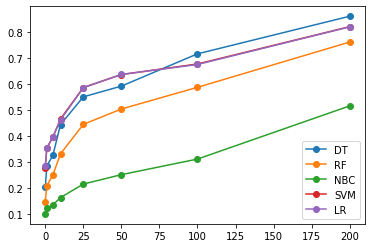

In [226]:
# Accuracy within range
def accuracy_range(y_test2, y_pred2, margin):
    return np.sum(np.absolute(y_test2 - y_pred2) <= margin) / len(y_test2)

for y_pred2 in [dt_y_pred2, rf_y_pred2, nbc_y_pred2, svm_y_pred2, lr_y_pred2]:
    plt.plot([0, 1, 5, 10, 25, 50, 100, 200],
             [accuracy_range(y_test2, y_pred2, margin) for margin in [0, 1, 5, 10, 25, 50, 100, 200]],
             linestyle='-', marker='o')

plt.legend(["DT", "RF", "NBC", "SVM", "LR"])
plt.show()